In [1]:
import pandas as pd
import numpy as np
import os,sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt

In [2]:
fdir = os.path.join(sys.path[0],"data/")
flist = os.listdir(fdir)
DataSet = {}
for file in flist:
    # print(file)
    Coinname = file.replace("coin_", "", 1).replace(".csv","",1)
    # print(Coinname)
    DataSet[Coinname] = pd.read_csv("data/"+file)

In [3]:
for key in DataSet:
    print(key)

Aave
BinanceCoin
Bitcoin
Cardano
ChainLink
Cosmos
CryptocomCoin
Dogecoin
EOS
Ethereum
Iota
Litecoin
Monero
NEM
Polkadot
Solana
Stellar
Tether
Tron
Uniswap
USDCoin
WrappedBitcoin
XRP


In [4]:
coin = "Bitcoin"
# DataSet["Bitcoin"].drop(columns=["SNo","Name","Symbol"])
df = DataSet[coin][['Date','Close']].set_index("Date")
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000


<AxesSubplot:xlabel='Date'>

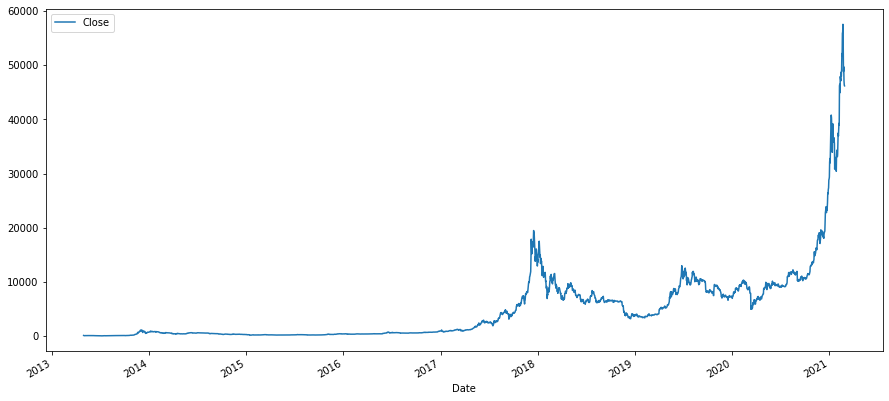

In [5]:
df.plot()

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from random import random
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
dfMonth = DataSet[coin].drop(columns=["SNo","Name","Symbol"]).set_index("Date")
dfMonth.index = pd.to_datetime(dfMonth.index)
dfMonth.sort_index(inplace=True)
dfMonth = dfMonth.resample('M').mean()

Dickey–Fuller test: p=0.998919


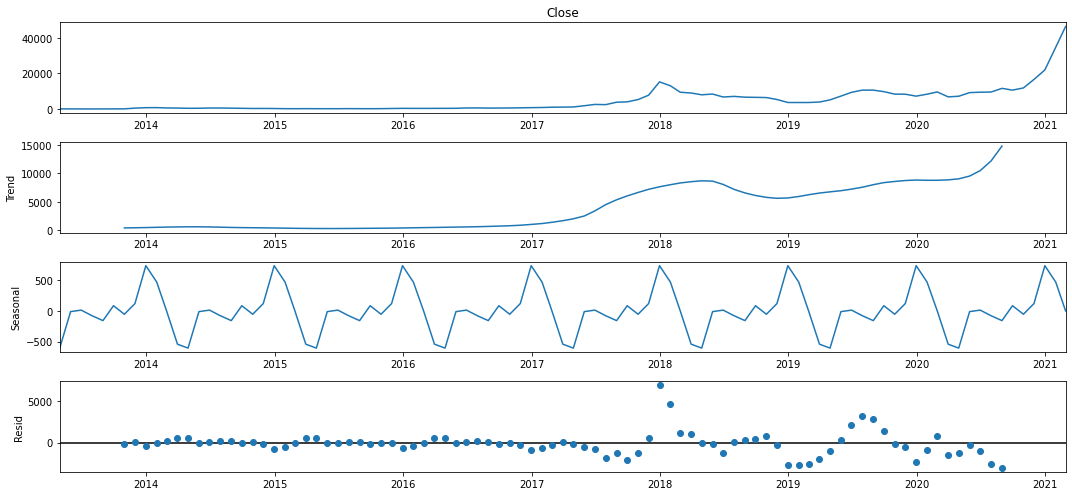

In [7]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(dfMonth.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.Close)[1])
plt.show()

In [8]:
dfMonth['Close_box'], lmbda = stats.boxcox(dfMonth.Close)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.Close_box)[1])

Dickey–Fuller test: p=0.856255


In [9]:
# Seasonal differentiation (12 months)
dfMonth['box_diff_seasonal_12'] = dfMonth.Close_box - dfMonth.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_12[12:])[1])


Dickey–Fuller test: p=0.631802


In [10]:
dfMonth['box_diff_seasonal_3'] = dfMonth.Close_box - dfMonth.Close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.019953


Dickey–Fuller test: p=0.000442


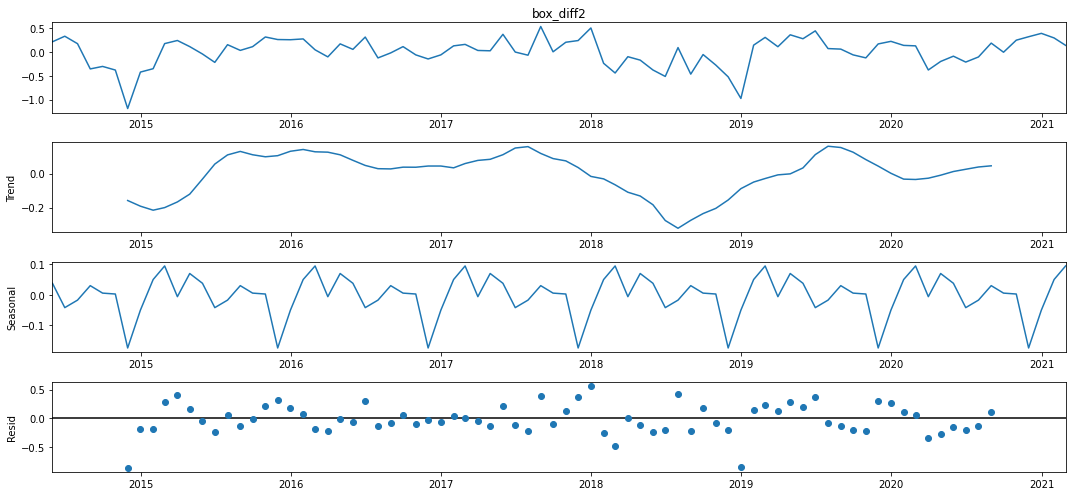

In [11]:
dfMonth['box_diff2'] = dfMonth.box_diff_seasonal_12 - dfMonth.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(dfMonth.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff2[13:])[1])

plt.show()

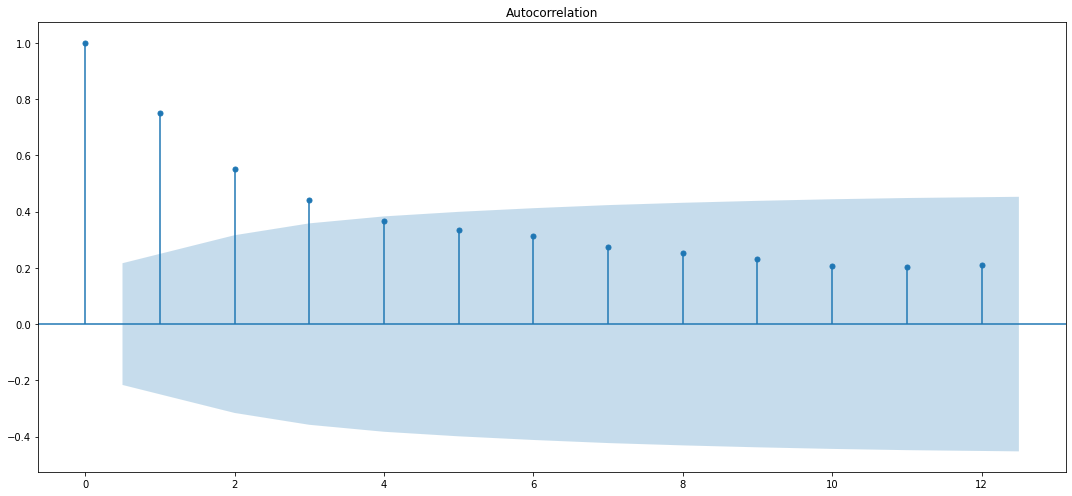

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#autocorrelation_plot(btc_month.Close)
plot_acf(dfMonth.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

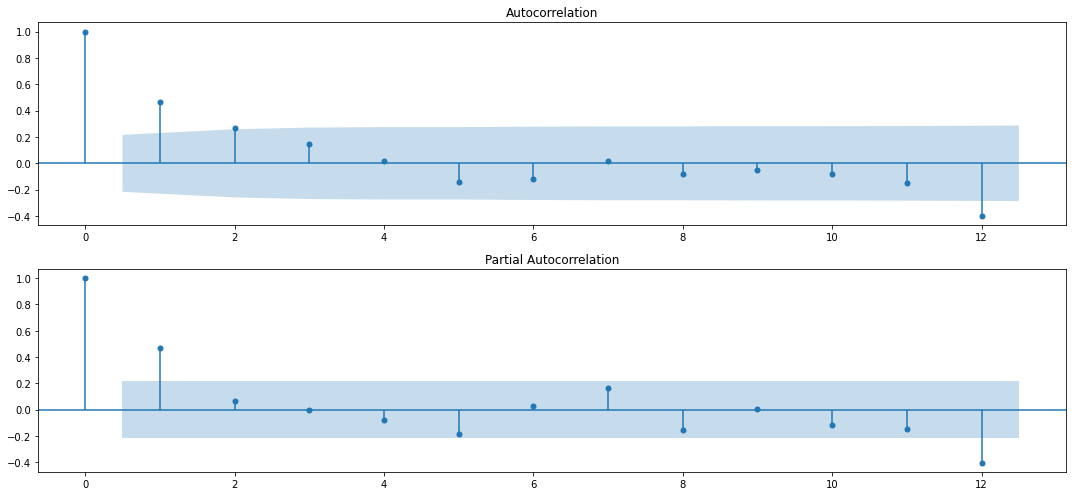

In [13]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(dfMonth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(dfMonth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from itertools import product
import warnings
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [15]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
3     (1, 0) -26.579614
1     (0, 1) -25.228748
4     (1, 1) -24.607245
6     (2, 0) -24.599110
7     (2, 1) -24.141584


In [16]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                   95
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  15.290
Date:                Wed, 26 May 2021   AIC                            -26.580
Time:                        02:18:32   BIC                            -21.493
Sample:                    04-30-2013   HQIC                           -24.525
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4093      0.101      4.038      0.000       0.211       0.608
sigma2         0.0422      0.003     13.470      0.000       0.036       0.048
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [17]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


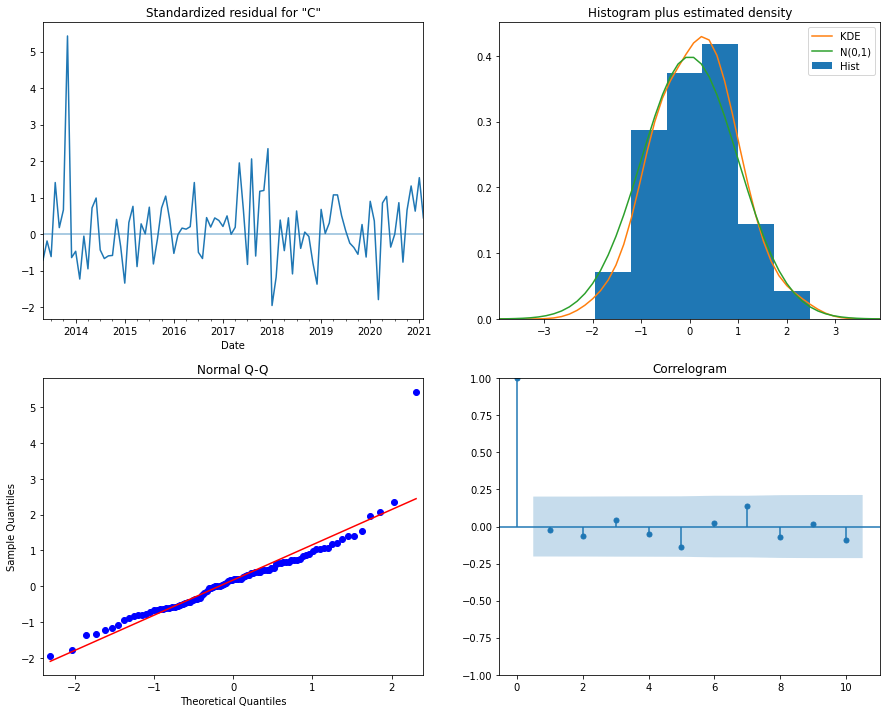

In [18]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [19]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

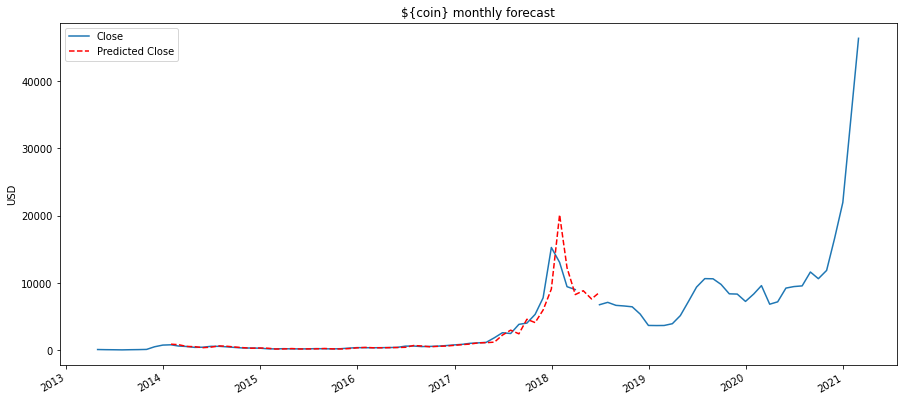

In [20]:
from datetime import datetime, timedelta

# Prediction
df_month_pred = dfMonth[['Close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
df_month_pred = pd.concat([df_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
df_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
df_month_pred.Close.plot()
df_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('${coin} monthly forecast')
plt.ylabel('USD')
plt.show()

In [21]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1) -10.708848
7   (0, 1, 0, 1) -10.117279
21  (1, 0, 1, 1)  -9.023386
25  (1, 1, 0, 1)  -8.810391
37  (2, 0, 0, 1)  -8.788393
                                      SARIMAX Results                                      
Dep. Variable:                           Close_box   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                   8.354
Date:                             Wed, 26 May 2021   AIC                            -10.709
Time:                                     02:18:49   BIC                             -3.209
Sample:                                 04-30-2013   HQIC                            -7.685
                                      - 02-28-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

In [23]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


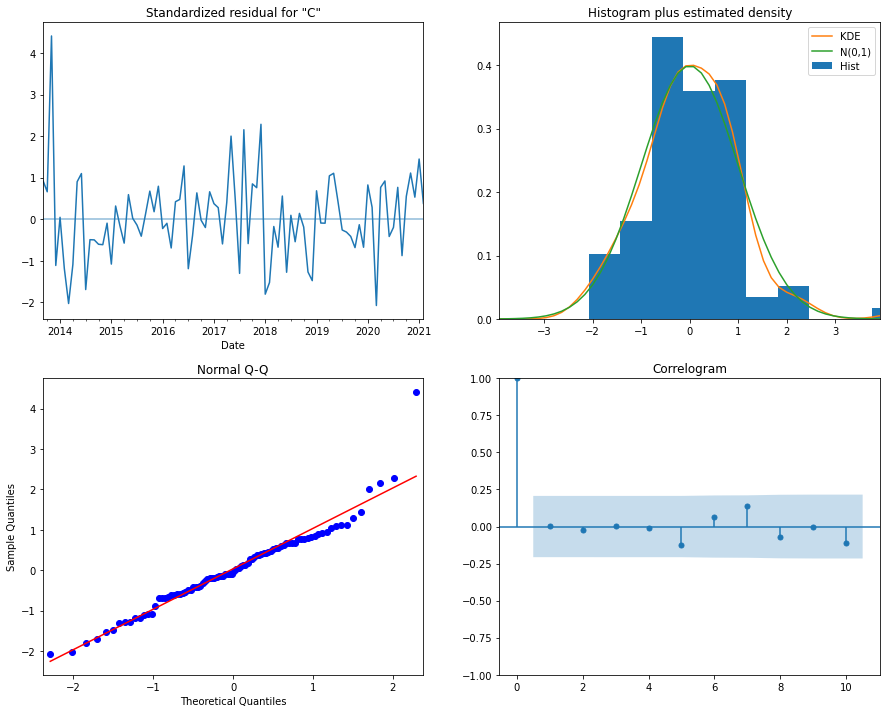

In [24]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


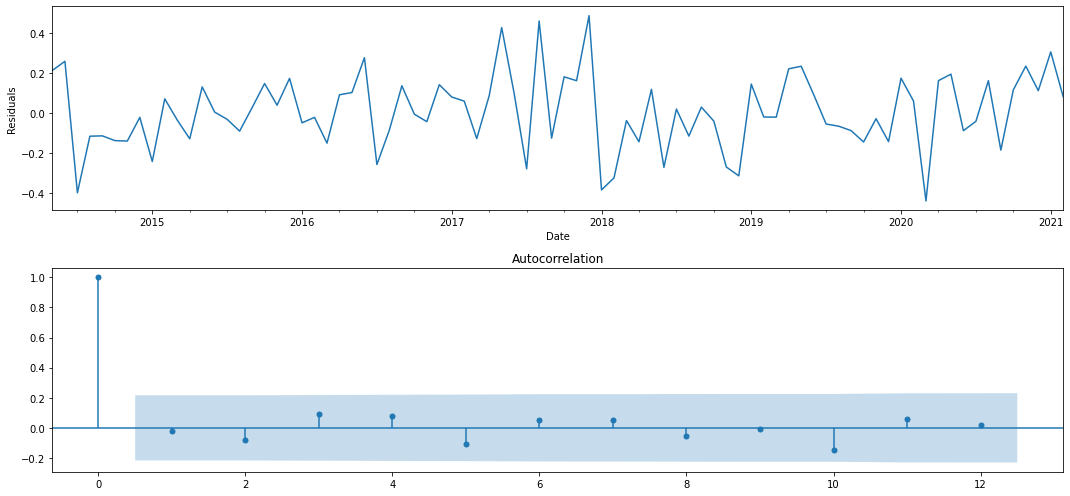

In [25]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [28]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

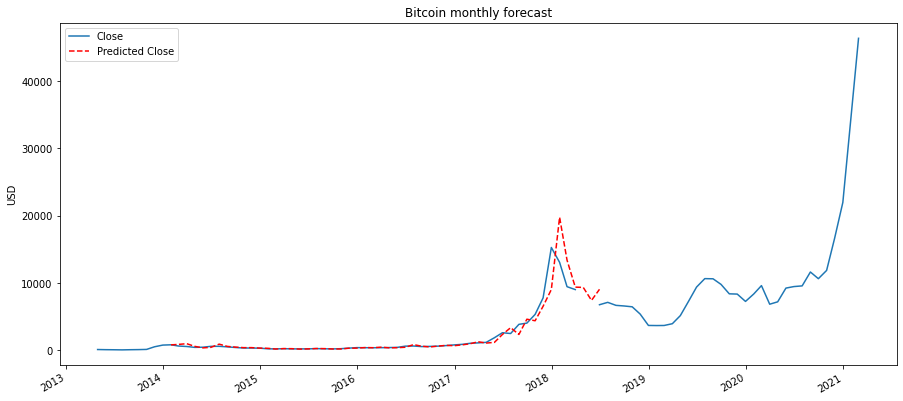

In [33]:
# Prediction
btc_month_pred = dfMonth[['Close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [34]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [35]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1) -10.708848
7   (0, 1, 0, 1) -10.117279
21  (1, 0, 1, 1)  -9.023386
25  (1, 1, 0, 1)  -8.810391
37  (2, 0, 0, 1)  -8.788393
                                      SARIMAX Results                                      
Dep. Variable:                           Close_box   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                   8.354
Date:                             Wed, 26 May 2021   AIC                            -10.709
Time:                                     02:24:06   BIC                             -3.209
Sample:                                 04-30-2013   HQIC                            -7.685
                                      - 02-28-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

In [36]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


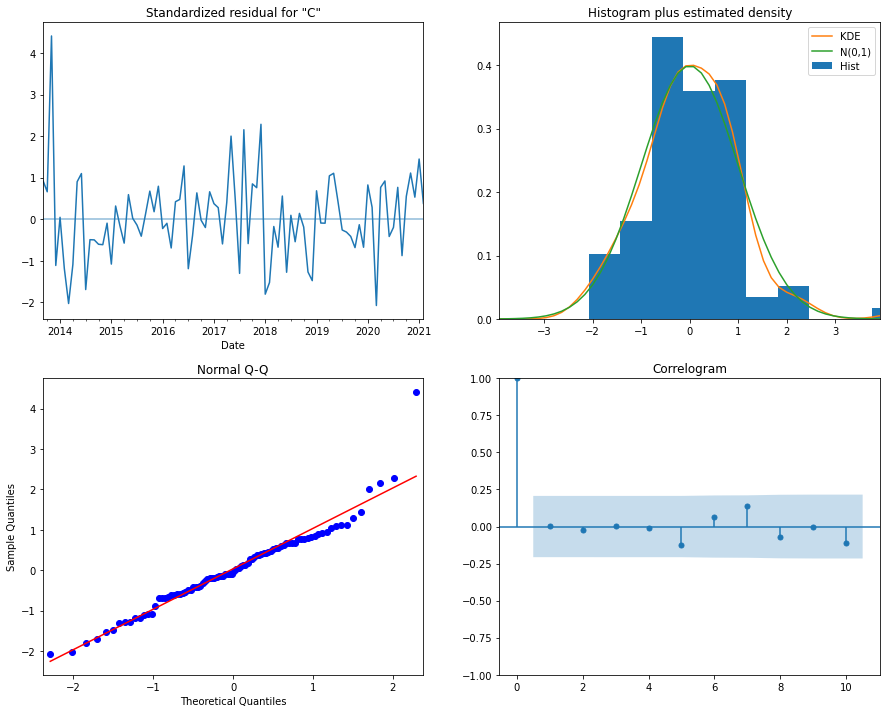

In [37]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


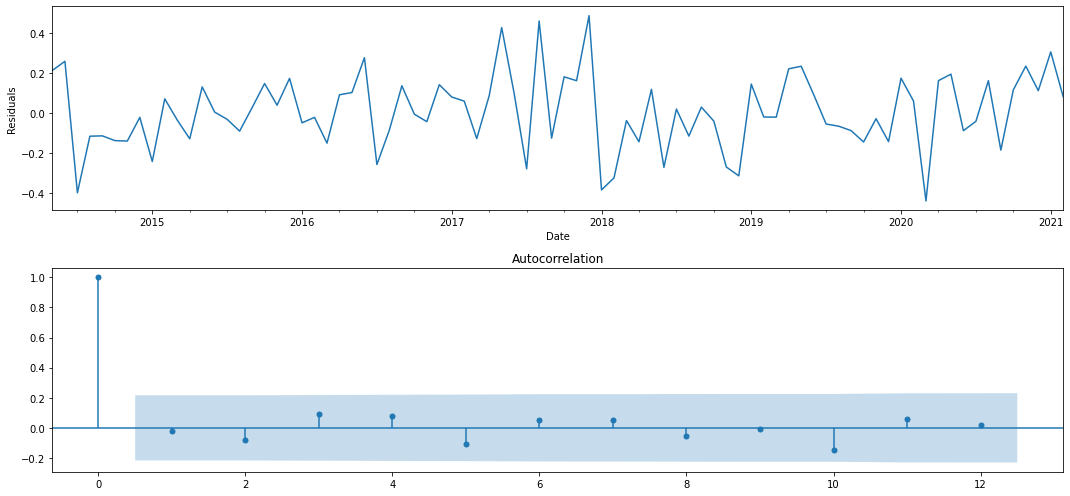

In [38]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

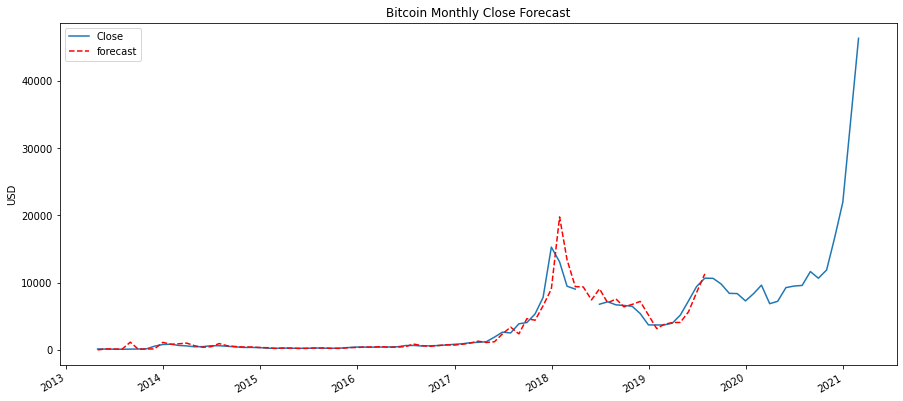

In [40]:
# Prediction
btc_month2 = dfMonth[['Close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [41]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2017-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

AssertionError: <class 'numpy.ndarray'>

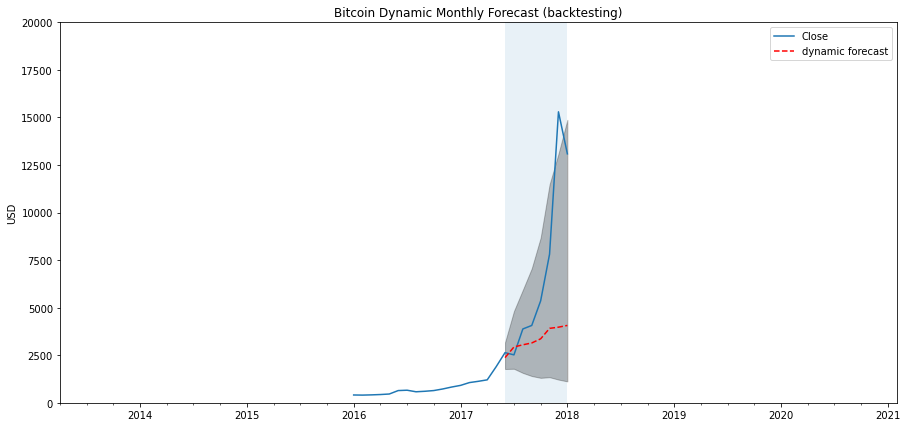

In [45]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower Close_box'] = invboxcox(pred_dynamic_ci['lower Close_box'], lmbda)
pred_dynamic_ci['upper Close_box'] = invboxcox(pred_dynamic_ci['upper Close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.Close['2016':'2018-01'].plot(label='Close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

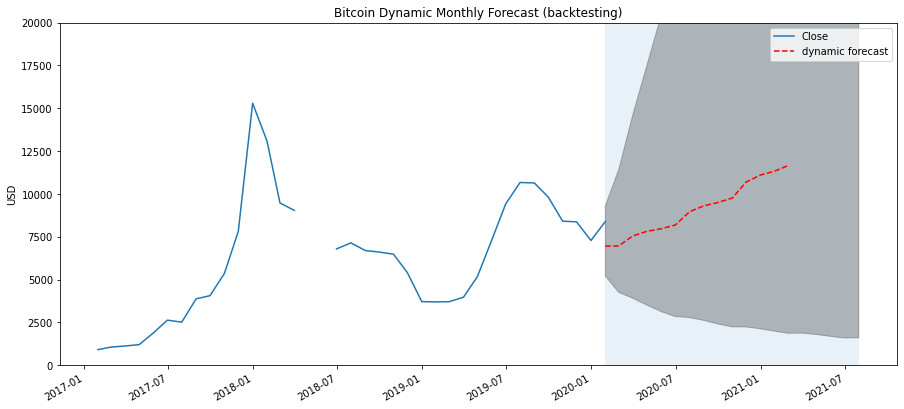

In [50]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2020-01-31')
t2 = pd.to_datetime('2021-07-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower Close_box'] = invboxcox(pred_dynamic_ci['lower Close_box'], lmbda)
pred_dynamic_ci['upper Close_box'] = invboxcox(pred_dynamic_ci['upper Close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.Close['2017':'2020-01'].plot(label='Close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()